## EY Data Challenge - Sentinel-2 Sample Notebook

This sample notebook can be used to create a Sentinel-2 satellite output product for a single date or a median mosaic for any time period. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The output from this notebook is a GeoTIFF product suitable for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI, NDBI, NDWI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [7]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

import os
# Common scientific & GIS libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Planetary Computer and STAC tools
import pystac_client
import planetary_computer 
from odc.stac import stac_load

# Geospatial vector data libraries
import geopandas as gpd
from shapely.geometry import shape

# Date/time handling
from datetime import date

In [8]:
# Download Sentinel-2 imagery, compute NDVI/NDBI/NDWI, and save as GeoTIFF
def download_sentinel_geotiff(
    lower_left: tuple,
    upper_right: tuple,
    time_window: str,
    filename: str
):
    # Define bounding box as (min_lon, min_lat, max_lon, max_lat)
    bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
    resolution = 10  # meters per pixel
    scale = resolution / 111320.0  # degrees per pixel (for EPSG:4326)

    # Connect to Planetary Computer STAC API and search for Sentinel-2 data
    print("🔍 Searching STAC...")
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bounds,
        datetime=time_window,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 30}},
    )
    items = list(search.get_items())
    print(f"📦 Found {len(items)} scenes.")

    # Raise error if no scenes found
    if not items:
        raise ValueError("No Sentinel-2 items found for given parameters.")

    # print("🔐 Signing items...")
    # signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    # Load data from signed STAC items
    print("📥 Loading data from STAC items...")
    data = stac_load(
        items,
        bands=["B02", "B03", "B04", "B08", "B11"],
        crs="EPSG:4326",
        resolution=scale,
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=bounds,
    )
    
    # Plot RGB preview of available images
    plot_data = data[["B04", "B03", "B02"]].to_array()
    plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)

    # Add a main title to the whole figure
    plt.suptitle("Time Series of Sentinel-2 RGB Images", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Compute median composite from time series
    print("🧮 Computing median composite...")
    median = data.median(dim="time").compute()

    # Calculate vegetation, built-up, and water indices
    print("🌿 Calculating NDVI, NDBI, NDWI...")
    ndvi_median = (median.B08 - median.B04) / (median.B08 + median.B04)
    ndbi_median = (median.B11 - median.B08) / (median.B11 + median.B08)
    ndwi_median = (median.B03 - median.B08) / (median.B03 + median.B08)
    
    # Plot NDVI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndvi_median.plot.imshow(ax=ax, cmap="RdYlGn", vmin=0.0, vmax=1.0)
    ax.set_title("Median NDVI")
    ax.axis("off")
    plt.show()
    
    # Plot NDBI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndbi_median.plot.imshow(ax=ax, cmap="jet", vmin=-0.1, vmax=0.1)
    ax.set_title("Median NDBI")
    ax.axis("off")
    plt.show()

    # Plot NDWI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndwi_median.plot.imshow(ax=ax, cmap="RdBu", vmin=-0.3, vmax=0.3)
    ax.set_title("Median NDWI")
    ax.axis("off")
    plt.show()

    # Assign CRS and transform
    height = median.dims["latitude"]
    width = median.dims["longitude"]
    gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
    median.rio.write_crs("epsg:4326", inplace=True)
    median.rio.write_transform(transform=gt, inplace=True);

    # Save NDVI, NDBI, NDWI as a 3-band GeoTIFF
    # Build the correct output path
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))   # repo root
    data_dir     = os.path.join(project_root, "data")
    os.makedirs(data_dir, exist_ok=True)          # ensure the folder exists
    output_path  = os.path.join(data_dir, filename)

    print(f"💾 Saving GeoTIFF to {output_path}...")
    
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        width=width,
        height=height,
        crs='epsg:4326',
        transform=gt,
        count=3,
        compress='lzw',
        dtype='float64'
    ) as dst:
        dst.write(ndvi_median,1)
        dst.write(ndbi_median,2)
        dst.write(ndwi_median,3) 
        dst.close()

    print("✅ GeoTIFF saved:", filename)

🔍 Searching STAC...
📦 Found 2 scenes.
📥 Loading data from STAC items...


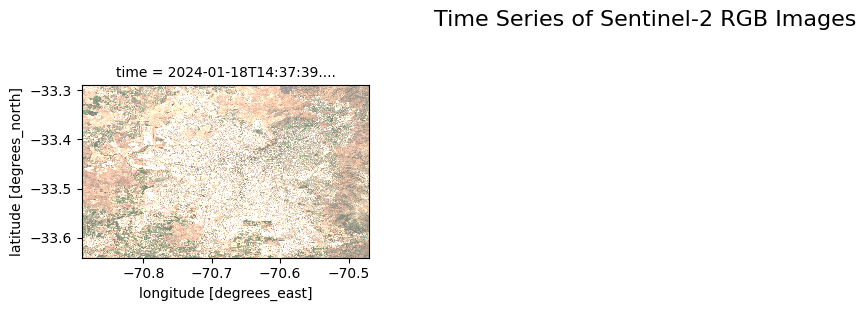

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


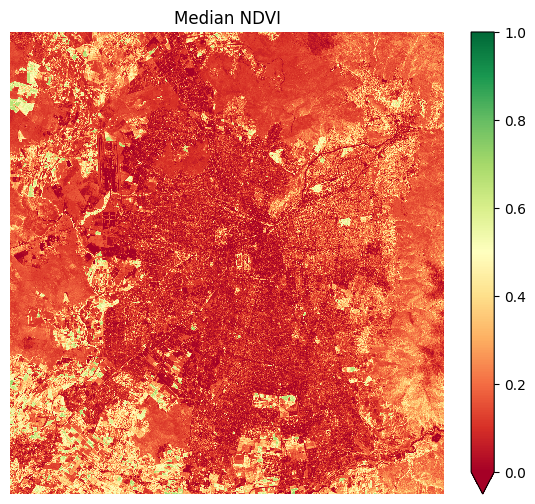

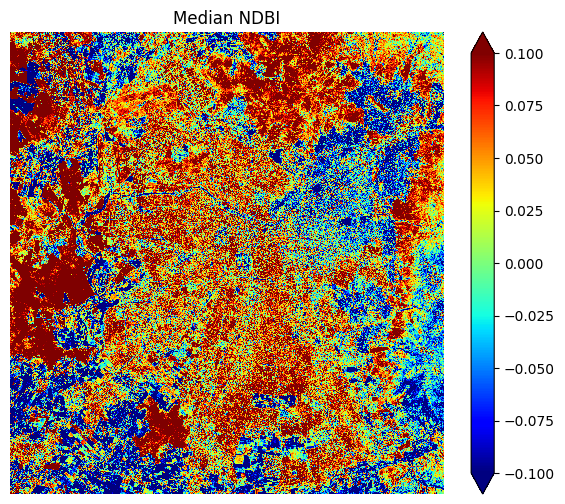

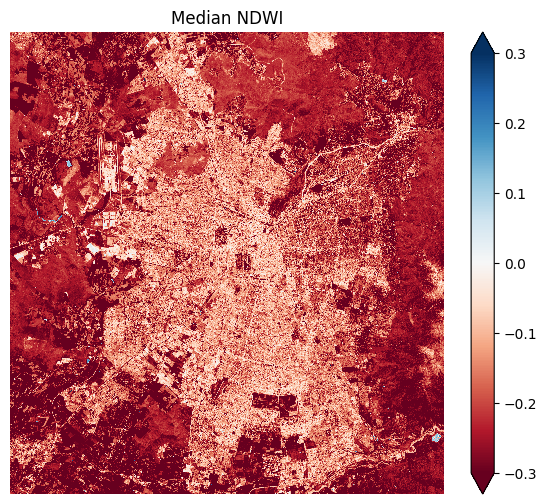

💾 Saving GeoTIFF to d:\Data Science\EY Urban Heat Island Challenge\data\sample_chile.tiff...
✅ GeoTIFF saved: sample_chile.tiff


In [9]:
# Santiago, Chile
download_sentinel_geotiff(
    lower_left=(-33.64, -70.89),
    upper_right=(-33.29, -70.47),
    time_window="2024-01-18/2024-01-18",
    filename="sample_chile.tiff"
)

🔍 Searching STAC...
📦 Found 2 scenes.
📥 Loading data from STAC items...


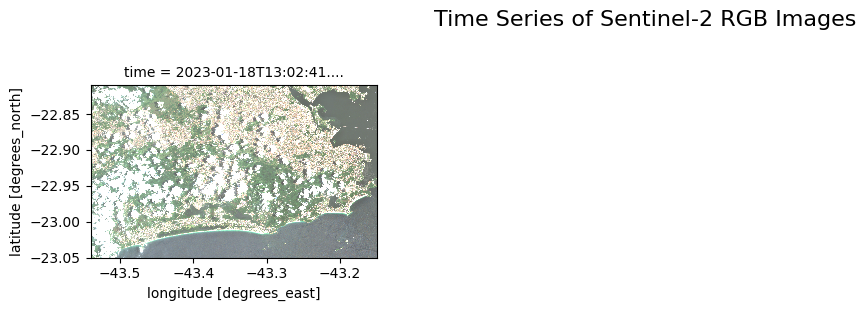

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


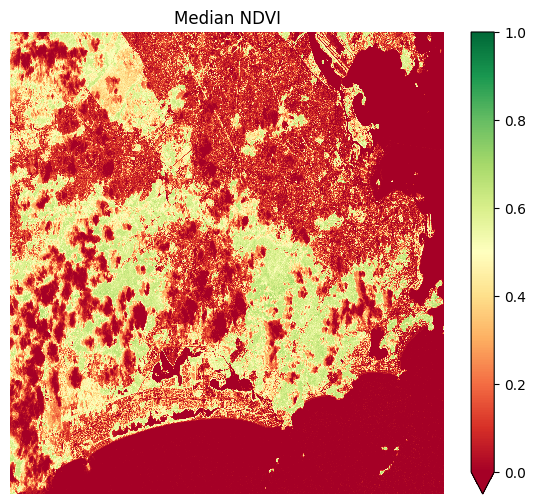

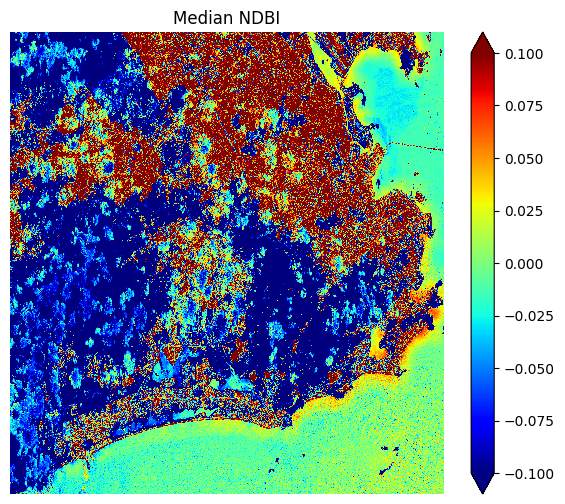

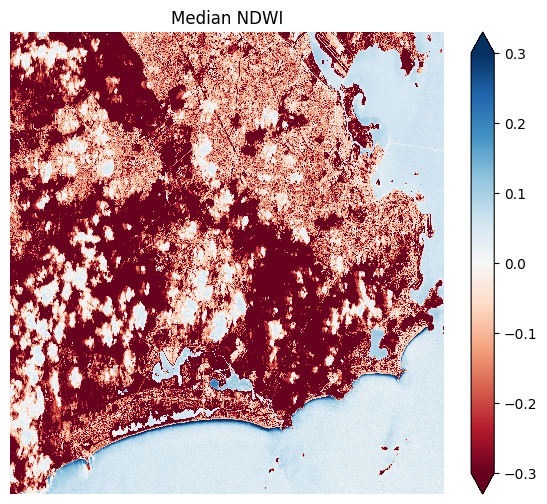

💾 Saving GeoTIFF to d:\Data Science\EY Urban Heat Island Challenge\data\sample_Brazil.tiff...
✅ GeoTIFF saved: sample_Brazil.tiff


In [10]:
# Rio, Brazil
download_sentinel_geotiff(
    lower_left=(-23.05, -43.54),
    upper_right=(-22.81, -43.15),
    time_window="2023-01-18/2023-01-18",
    filename="sample_Brazil.tiff"
)

🔍 Searching STAC...
📦 Found 4 scenes.
📥 Loading data from STAC items...


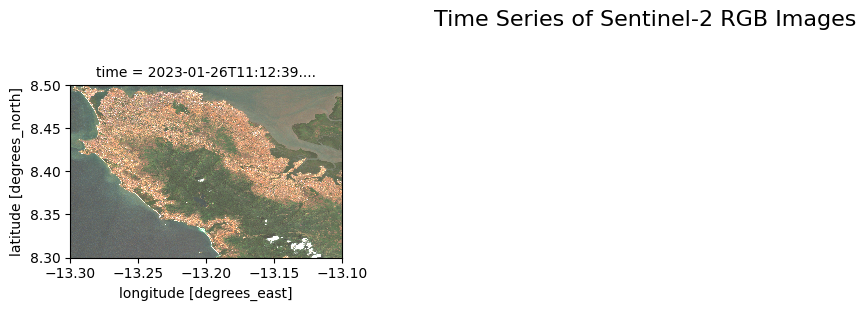

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


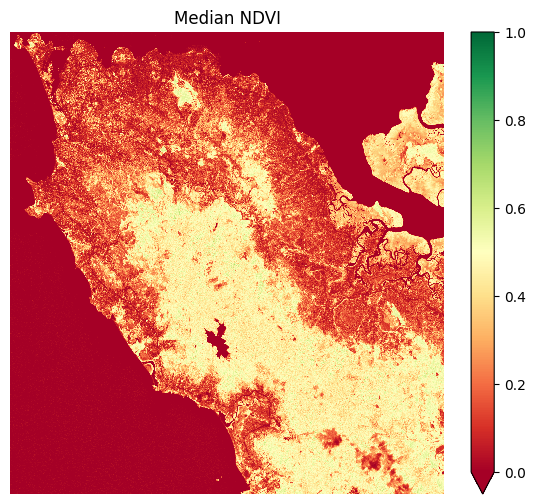

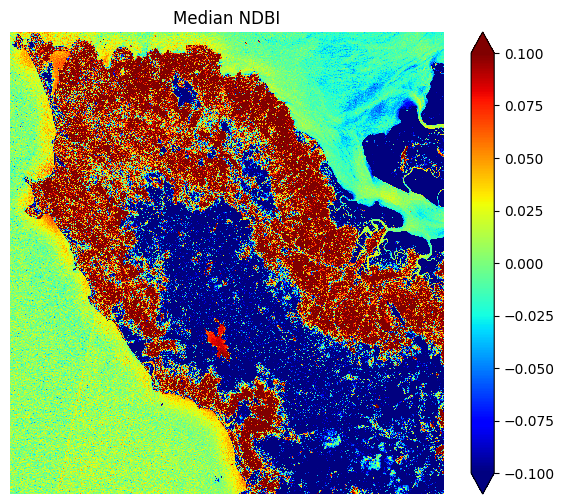

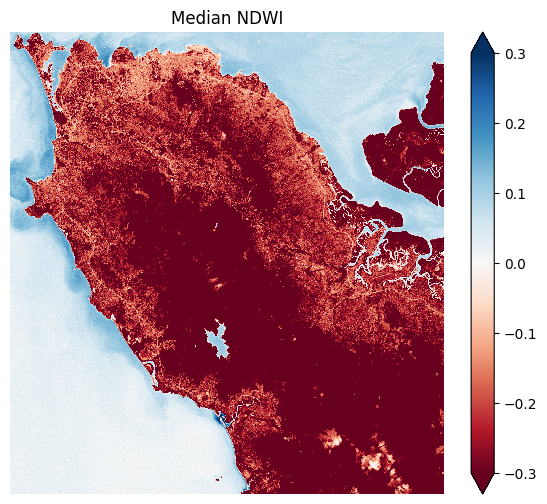

💾 Saving GeoTIFF to d:\Data Science\EY Urban Heat Island Challenge\data\sample_Sierra.tiff...
✅ GeoTIFF saved: sample_Sierra.tiff


In [11]:
# Freetown, Sierra Leone
download_sentinel_geotiff(
    lower_left=(8.30, -13.30),
    upper_right=(8.50, -13.10),
    time_window="2023-01-26/2023-01-26",
    filename="sample_Sierra.tiff"
)